# Exploring Gender Bias in Word Embeddings

This lab is based on a tutorial for the responsibly Python package. You can view the original tutorial and learn more about responsibly here: [https://learn.responsibly.ai/word-embedding](https://learn.responsibly.ai/word-embedding).

Please go through this notebook by running each cell and answering the questions which occur at the end of each part. Some will involve you coding while others will simply require that you write a response in markdown. The questions are marked by whales (🐳).

#### Note: You will be using a smaller version of the the full Word2Vec (which compressed is still about 2GB). You may find that some words you want to use for the assignment are not included in the smaller dictionary. You may have to find words to use by trial and error.

# Part 1: Setup

## 1.1 - Install and load packages

- On a mac, open a terminal window
- make a conda environment with strictly less than Python 3.8 but greater than or equal to Python 3.6

conda create -n py37 python=3.7 anaconda

conda activate py37

- **Install numpy and matplotlib (v2.2.3) through conda**

conda install numpy

conda install matplotlib=2.2.3

pip install responsibly

- On a mac you then load Jupyter Notebook by typing the command below.  The ampersand is to run the notebook in the "background", that is to allow you to continue typing other commands in the same terminal window.

jupyter-notebook& 



In [3]:
from IPython.display import Image
import warnings
from math import acos, degrees
from operator import itemgetter
from copy import deepcopy

# matplotlib
from matplotlib import pylab as plt
import matplotlib.pylab as plt

# numpy
from numpy.testing import assert_almost_equal
from numpy.linalg import norm

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

# responsibly
import responsibly
from responsibly.we import most_similar
from responsibly.we import GenderBiasWE
from responsibly.we import load_w2v_small
from responsibly.we import calc_all_weat
from responsibly.we import calc_single_weat
from responsibly.we import GenderBiasWE


## 1.2 - Validate Installation of `responsibly`

In [4]:
# You should get '0.1.3'
responsibly.__version__

'0.1.3'

# Part 2: Motivation - Why use word embeddings?

## 2.1 - [NLP (Natural Language Processing)](https://en.wikipedia.org/wiki/Natural_language_processing)

Partial list of tasks and applications:

- Classification
- Machine Translation
- Information Retrieval
- Conversation Chatbots
- Coreference Resolution

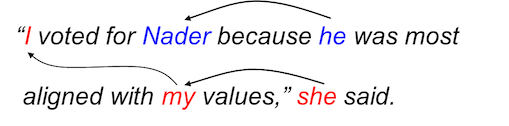

In [6]:
Image("./images/corefexample.png", width=600)


<small>Source: [Stanford Natural Language Processing Group](https://nlp.stanford.edu/projects/coref.shtml)</small>

## 2.2 - Machine Learning (NLP) Pipeline

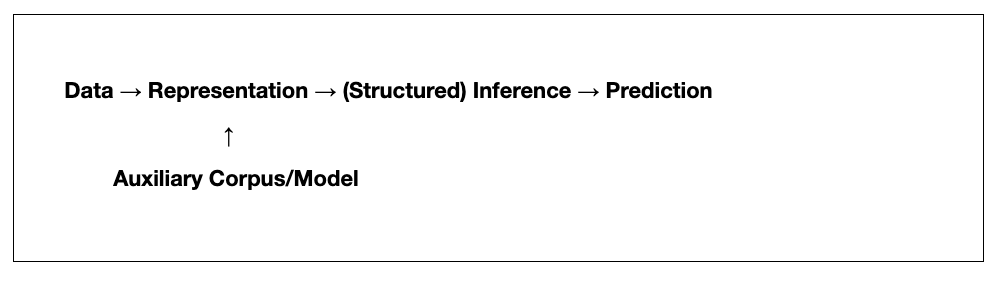

In [7]:
Image("./images/nlp-pipeline.png", width=600)


<small>Source: [Kai-Wei Chang (UCLA) - What It Takes to Control Societal Bias in Natural Language Processing](https://www.youtube.com/watch?v=RgcXD_1Cu18)</small>

## 2.3 - How can we represent language to a machine?

We need some kind of *dictionary* to transform/encode from a human representation to a machine representation (words → numbers)

### Bag of Words (for a text)


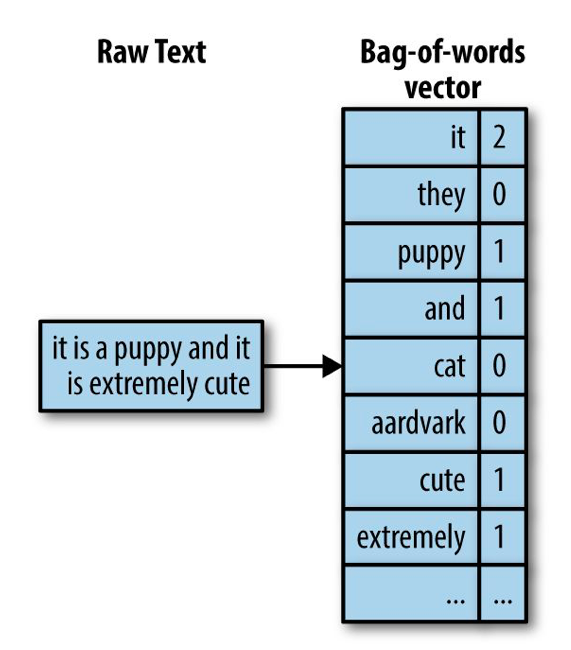

In [8]:
Image("./images/bow.png", width=300)

<small>Source: Zheng, A.& Casari, A. (2018). Feature Engineering for Machine Learning. O'Reilly Media.</small>

In [9]:
vocabulary = ['it', 'they', 'puppy', 'and', 'cat', 'aardvark', 'cute', 'extremely', 'not']

vectorizer = CountVectorizer(vocabulary=vocabulary)

In [10]:
sentence = 'it is a puppy and it is extremely cute'

In [11]:
vectorizer.fit_transform([sentence]).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 0]])

In [12]:
vectorizer.fit_transform(['it is not a puppy and it is extremely cute']).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 1]])

In [13]:
vectorizer.fit_transform(['it is a puppy and it is extremely not cute']).toarray()

array([[2, 0, 1, 1, 0, 0, 1, 1, 1]])

Read more about scikit-learn's text feature extraction [here](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction).

### One-hot representation

In [14]:
[vectorizer.fit_transform([word]).toarray()
 for word in sentence.split()
 if word in vocabulary]

[array([[1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 1, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 array([[0, 0, 0, 0, 0, 0, 1, 0, 0]])]

### A problem with one-hot representation


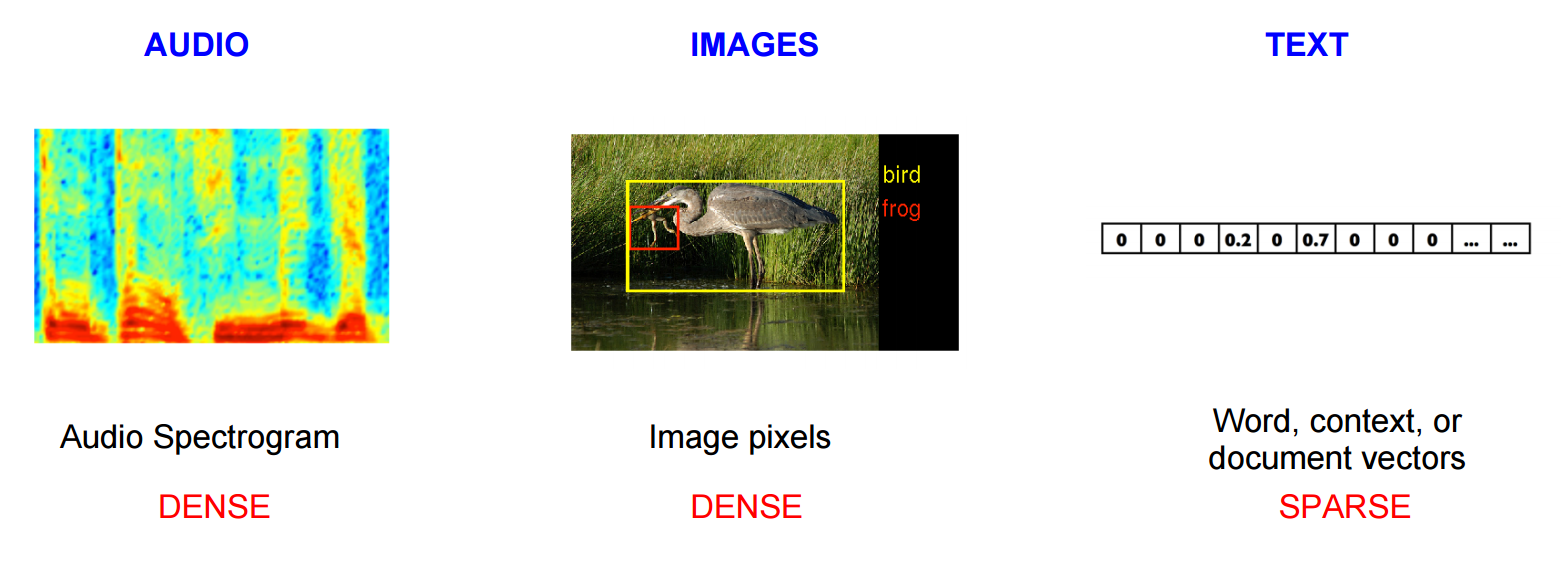

In [15]:
Image("./images/audio-image-text.png", width=600)

<small> Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec) </small>

### Embedding a word in a n-dimensional space

Distance ~ Semantic Similarity

Again, for the purposes of this assignment, these are just references and additional sources of information. You should have already seen "The Illustrated Word2vec" by Jay Alammar.

#### Examples (algorithms and pre-trained models)
- [Word2Vec](https://code.google.com/archive/p/word2vec/)
- [GloVe](https://nlp.stanford.edu/projects/glove/)
- [fastText](https://fasttext.cc/)
- [ELMo](https://allennlp.org/elmo) (contextualized)

#### Training: using *word-context* relationships from a corpus.

See: [The Illustrated Word2vec by Jay Alammar](http://jalammar.github.io/illustrated-word2vec/)

#### State of the Art - Contextual Word Embedding → Language Models
- [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning) by Jay Alammar](http://jalammar.github.io/illustrated-bert/)
- Microsoft - [NLP Best Practices](https://github.com/microsoft/nlp-recipes)
- [Tracking Progress in Natural Language Processing](https://nlpprogress.com/)

## 🐳 **Questions** 🐳

- What is the difference between the bag-of-words approach and the one-hot encoding demonstrated here?

In the bag-of-words approach, the vocabulary list is represented by a N dimensional vector, where N is the number of words in the vocabulary. The ith entry of the array corresponds to the frequency of the ith word in the vocabulary appearing in the sentence. 

In the one-hot encoding approach, the vocabulary list is represented by an M by N dimensional array, where M is the number of times a word from the vocabulary appears in the sentence, and N is the number of the words in the vocabulary. If the ith word of the vocabulary is in the sentence, then it is encoded as a 1 at the ith spot in each row and all other entires are 0 for that row.


+ Can you think of a use case where one-hot encoding or a bag of words approach would be better than a high-dimensional word embedding? If so, why? If not, why not?

You would use one-hot encoding or a bag of words approach if you are only concerned with counting the frequency that words appear in a sentence. If you are more concerned with determining the co-occurences of specific words and thus deduce word similarity, then high-demensional word embedding should be used. 

# Part 3: Playing with Word2Vec word embeddings


[Word2Vec](https://code.google.com/archive/p/word2vec/) - Google News - 100B tokens, 3M vocab, cased, 300d vectors - only lowercase vocab extracted

Loaded using [`responsibly`](http://docs.responsibly.ai) package, the function [`responsibly.we.load_w2v_small`]() returns a [`gensim`](https://radimrehurek.com/gensim/)'s [`KeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors) object.

## 3.1 - Basic Properties

In [16]:
# ignore warnings
# generally, you shouldn't do that, but for this tutorial we'll do so for the sake of simplicity
warnings.filterwarnings('ignore')

In [17]:
# this loads a small version of Word2Vec which does not include the full vocabulary 
w2v_small = load_w2v_small()

In [18]:
# vocabulary size
len(w2v_small.vocab)

26423

In [19]:
# get the vector of the word "home"
print('home =', w2v_small['home'])

home = [-0.00584168  0.0392657   0.00831084 -0.0443245   0.0426382   0.0119243
  0.0125867  -0.0934669   0.0698593   0.0416747   0.0838311  -0.123338
 -0.0263779  -0.0139718   0.0224031  -0.07275     0.00605246  0.0278233
  0.00963576  0.106475    0.0775679  -0.0785314   0.0436018  -0.052274
 -0.00201749 -0.0115027  -0.0243303   0.0402293   0.0187897   0.00087324
  0.027221    0.0184284  -0.0722682  -0.0187897  -0.027221    0.00560078
 -0.0387839  -0.0737135   0.0445654   0.0183079   0.0436018  -0.00731715
  0.0900943   0.047697   -0.027221    0.0804586   0.0195124   0.0809404
  0.0414338   0.0137912  -0.016983    0.146464    0.0693775   0.0486606
 -0.0910579  -0.130083   -0.0597417   0.0900943   0.0112618  -0.0209578
 -0.0101778   0.0407111  -0.00069257  0.0110811  -0.0375795   0.0133696
 -0.0232463   0.0278233  -0.00123458  0.0558874   0.063596   -0.047697
  0.0332434  -0.0402293  -0.0520331   0.0344478  -0.011322    0.0030714
  0.00909375 -0.0128878   0.0285459   0.0380612   0.00502

In [20]:
# the word embedding dimension, in this case, is 300

len(w2v_small['home'])

300

In [21]:
# all the words are normalized (=have norm equal to one as vectors)

norm(w2v_small['home'])

1.0

In [22]:
# make sure that all the vectors are normalized!

length_vectors = norm(w2v_small.vectors, axis=1)

assert_almost_equal(actual=length_vectors,
                    desired=1,
                    decimal=5)

## 3.2 - Mesuring Distance between Words

### Mesure of Similiarty: [Cosine Similariy](https://en.wikipedia.org/wiki/Cosine_similarity)
- Measures the cosine of the angle between two vecotrs.
- Ranges between 1 (same vector) to -1 (opposite/antipode vector)
- In Python, for normalized vectors (Numpy's array), use the `@`(at) operator

In [23]:
w2v_small['cat'] @ w2v_small['cat']

1.0000005

In [24]:
w2v_small['cat'] @ w2v_small['cats']

0.8099383

In [25]:
degrees(acos(w2v_small['cat'] @ w2v_small['cats']))

35.910095270739426

In [26]:
w2v_small['cat'] @ w2v_small['dog']

0.76094615

In [27]:
degrees(acos(w2v_small['cat'] @ w2v_small['dog']))

40.45232006805675

In [28]:
w2v_small['cat'] @ w2v_small['cow']

0.40352482

In [29]:
degrees(acos(w2v_small['cat'] @ w2v_small['cow']))

66.20128249356603

In [30]:
w2v_small['cat'] @ w2v_small['graduated']

-0.0037888307

In [31]:
degrees(acos(w2v_small['cat'] @ w2v_small['graduated']))

90.2170845284977

In general, the use of word embeddings to encode words, as an input for NLP systems*, improves their performance compared to one-hot representation.

\* Sometimes the embedding is learned as part of the NLP system.

## 3.3 - Visualizing Word Embedding in 2D using T-SNE

<small>Source: [Google's Seedbank](https://research.google.com/seedbank/seed/pretrained_word_embeddings)</small>

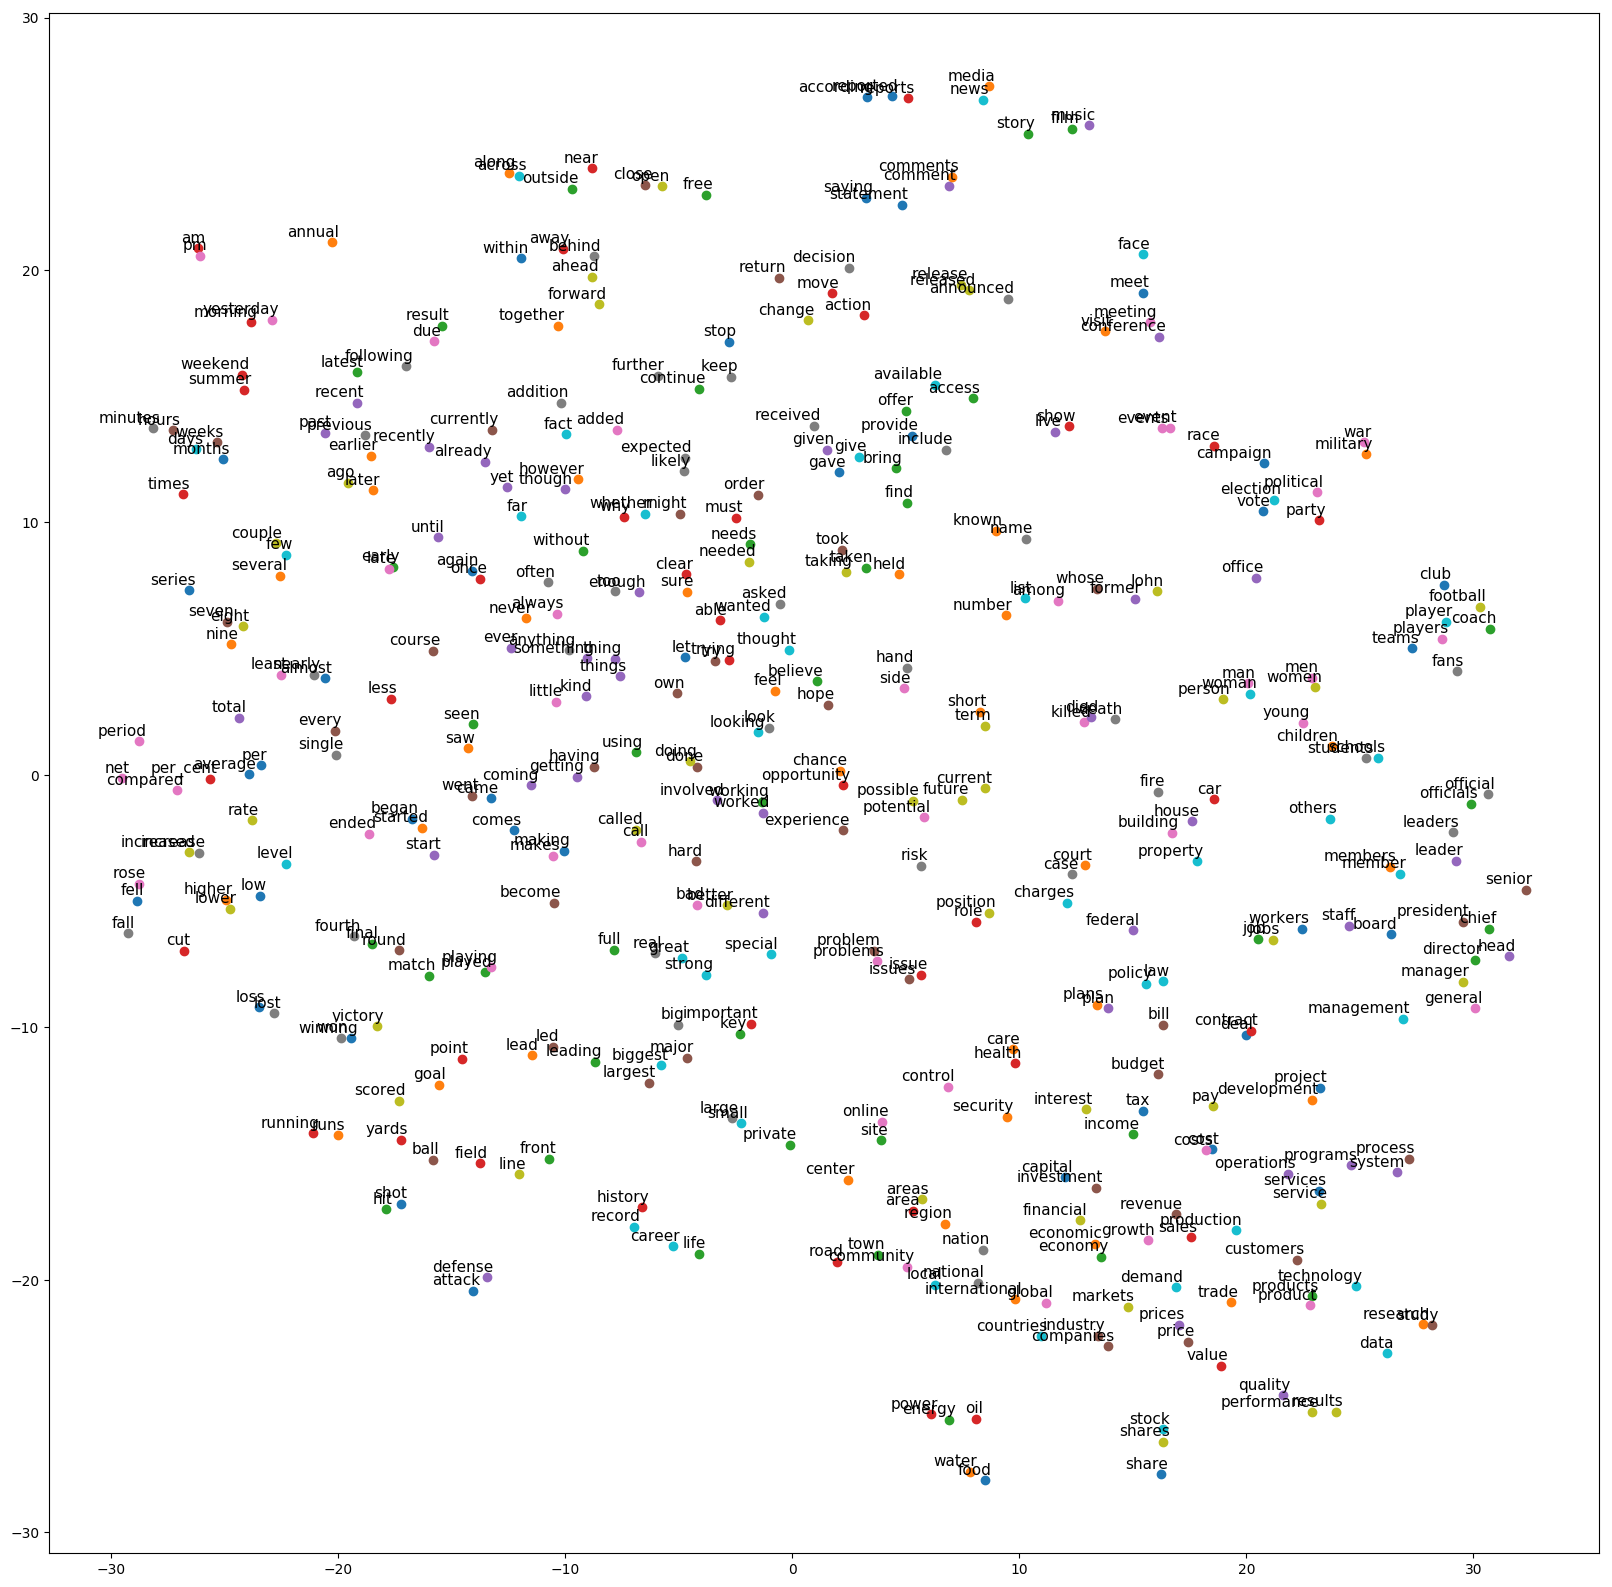

In [41]:


# take the most common words in the corpus between 200 and 600
words = [word for word in w2v_small.index2word[200:600]]

# convert the words to vectors
embeddings = [w2v_small[word] for word in words]

# perform T-SNE
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

#### Extra: [Tensorflow Embedding Projector](http://projector.tensorflow.org)

## 3.4 - Most Similar

What are the most simlar words to a given word?

In [33]:
w2v_small.most_similar('cat')

[('cats', 0.8099379539489746),
 ('dog', 0.7609457969665527),
 ('kitten', 0.7464984655380249),
 ('feline', 0.7326232194900513),
 ('puppy', 0.707545280456543),
 ('pup', 0.6934289336204529),
 ('pet', 0.6891531348228455),
 ('pooch', 0.6699830889701843),
 ('poodle', 0.662124752998352),
 ('dogs', 0.6418519020080566)]

Given a list of words, which one doesn't match?

(The word furthest away from the mean of all words.)

In [34]:
w2v_small.doesnt_match('breakfast cereal dinner lunch'.split())

'cereal'

## 3.5 - Vector Arithmetic

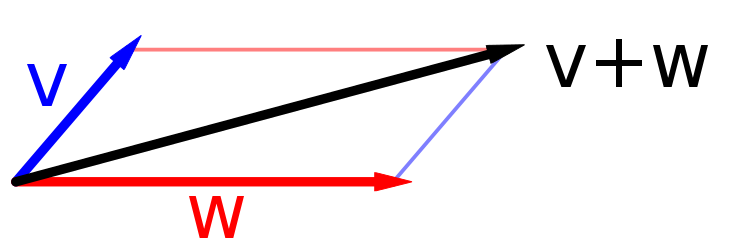

In [35]:
Image("./images/vector-addition.png", width="400")


<small>Source: [Wikipedia](https://commons.wikimedia.org/wiki/File:Vector_add_scale.svg)</small>

In [36]:
# nature + science = ?

w2v_small.most_similar(positive=['nature', 'science'])

[('biology', 0.5784977078437805),
 ('ecology', 0.5561813712120056),
 ('scientific', 0.548497200012207),
 ('sciences', 0.5216707587242126),
 ('physics', 0.49387648701667786),
 ('geography', 0.4893346130847931),
 ('geology', 0.48859816789627075),
 ('mathematics', 0.48719537258148193),
 ('humanities', 0.48349496722221375),
 ('astronomy', 0.4645444452762604)]

## 3.6 - Vector Analogy

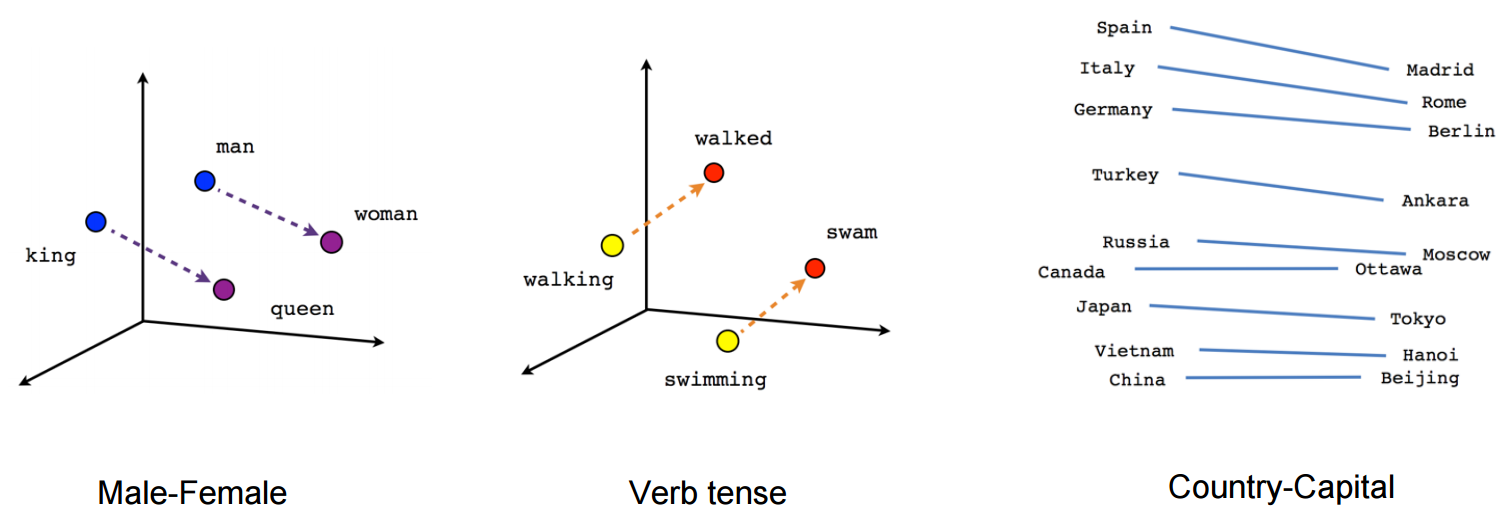

In [37]:
Image("./images/linear-relationships.png", width=800)

<small>Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec)</small>

We now try to represent the following analogy: 

*king is to man as ____ is to woman*

We can think of this as $\overrightarrow{king} - \overrightarrow{man} + \overrightarrow{woman}$

In [38]:
w2v_small.most_similar(positive=['king', 'woman'],
                       negative=['man'])

[('queen', 0.7118192315101624),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431011199951),
 ('prince', 0.5377321839332581),
 ('kings', 0.5236842632293701),
 ('queens', 0.5181134939193726),
 ('monarchy', 0.5087413191795349),
 ('throne', 0.5005807876586914),
 ('royal', 0.493820458650589),
 ('ruler', 0.49092739820480347)]

## 3.7 - Think about a direction in word embedding as a relation

Remember: direction is not a word vector by itself

$\overrightarrow{big} - \overrightarrow{small} + \overrightarrow{smaller}$

In [39]:
w2v_small.most_similar(positive=['big', 'smaller'],
                       negative=['small'])

[('bigger', 0.7836998701095581),
 ('larger', 0.5866796374320984),
 ('biggest', 0.5240509510040283),
 ('huge', 0.5084123611450195),
 ('sharper', 0.48242905735969543),
 ('heavier', 0.4784499704837799),
 ('tougher', 0.46322110295295715),
 ('better', 0.46317413449287415),
 ('major', 0.45621880888938904),
 ('quicker', 0.4514269232749939)]

Sometimes vector arithmetic does not behave as expect. Notice how close the top two results are in the output that follows.

$\overrightarrow{up} - \overrightarrow{down} + \overrightarrow{backward}$

(we include backwards in the code, otherwise it will be the top result)

In [40]:
w2v_small.most_similar(positive=['up', 'backward', 'backwards'],
                       negative=['down'])

[('forward', 0.42214247584342957),
 ('bending', 0.4208742082118988),
 ('awkwardly', 0.41121649742126465),
 ('wrong', 0.40030157566070557),
 ('towards', 0.3958849608898163),
 ('direction', 0.3805443048477173),
 ('toward', 0.3803451359272003),
 ('opposite_direction', 0.378280371427536),
 ('twisting', 0.3676390051841736),
 ('upwards', 0.3630780279636383)]

#### Extra Information

Keep in mind the word embedding was generated by learning the co-occurrence of words, so the fact that it *empirically* exhibits "concept arithmetic", it doesn't necessarily mean it learned it! In fact, it seems it didn't.
See: [king - man + woman is queen; but why? by Piotr Migdał](https://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html)

[Demo - Word Analogies Visualizer by Julia Bazińska](https://lamyiowce.github.io/word2viz/)

In fact, `w2v_small.most_similar` finds the closest word which *is not one* of the given ones. This is a real methodological issue. Nowadays, it is not a common practice anymore to evaluate word embedding with analogies.

You can use [`responsibly.we.most_similar`](https://docs.responsibly.ai/word-embedding-bias.html#responsibly.we.utils.most_similar) for the unrestricted version.

## 🐳 **Questions** 🐳

+ What are some of the advantages and disadvantages of the 2-dimensional visualization in **3.3**?

<br>

The advantages of the 2-dimensional visualitation in 3.3 is that you can clearly visualize the perceived similarity between words by measuring the distance between the data points on the graph. The disadvantages are that you do not know what the axes of the visualization represent since the dimensionality of the original dataset have been compressed into 2 dimensions.

+ What makes sense to you about what you see in the 2-dimensional visualization in **3.3** and what doesn't?

<br>

Words that do have similar meanings or contexts are close to each other in distance. For instance, minutes, hours weeks and months are all close to one another and these are all metrics of time. However, words that seem quite dissimilar are also sometimes close to each other on the graph. One example of this is that the closest word to 'stop' on the visualization is 'keep.' These words don't have much similar meaning or context yet are close to each other on the 2-D visualization.

+ Why did the vector arithmetic in **3.6** appear to work but it did not in the latter part of **3.7**?

<br>

Word embedding is generated by learning the co-occurence of words and does not actually learn meanings of words. Words that mean similar things or have similar contexts often co-occur together. Sometimes, though there is more than one context in which words often co-occur together. In 3.6, queen was the clear winner in terms of being most associated with king and woman and least associated with man. However in 3.7, forward and bending were both about even in terms of being associated with up, backward and backwards and not associated with down. That is why in this case, the vector arithmetic was less accurate.


+ Find the words that are most similar to this relation: *see* is to *eye* as ___ is to *ear*
The 3 most similar words to this relation are hear, listen and find.

In [43]:
w2v_small.most_similar(positive=['see', 'ear'],
                       negative=['eye'])

[('hear', 0.5891357064247131),
 ('listen', 0.4594334661960602),
 ('find', 0.44554945826530457),
 ('tell', 0.4436537027359009),
 ('know', 0.4356938302516937),
 ('imagine', 0.42920711636543274),
 ('heard', 0.41161656379699707),
 ('think', 0.4051738381385803),
 ('get', 0.3973262310028076),
 ('do', 0.39647242426872253)]

+ Pick a relation of your own and find words most similar to it. What did you expect to see, and what did you find? (Note that the dictionary used here is limited and you may have to experiment to find words that are included.)

Relation 1: Minutes are to hours as __ are to months. Correct answer: weeks. The code below shows that weeks has the highest similarity score for the above relation.

In [44]:
w2v_small.most_similar(positive=['minutes', 'months'],
                       negative=['hours'])

[('weeks', 0.6301729083061218),
 ('years', 0.579207718372345),
 ('minute', 0.4986867308616638),
 ('month', 0.48650896549224854),
 ('days', 0.48530033230781555),
 ('quarters', 0.4672534167766571),
 ('seconds', 0.4598607122898102),
 ('year', 0.45607995986938477),
 ('half', 0.43466565012931824),
 ('fortnight', 0.43069836497306824)]

# Part 4: Gender Bias


Remember that Word2Vec is primarily trained on Google News.

Bolukbasi Tolga, Kai-Wei Chang, James Y. Zou, Venkatesh Saligrama, and Adam T. Kalai. [Man is to computer programmer as woman is to homemaker? debiasing word embeddings](https://arxiv.org/abs/1607.06520). NIPS 2016.

In [1]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

The method of generating analogies can enforce producing gender sterotyping ones -

Nissim, M., van Noord, R., van der Goot, R. (2019). [Fair is Better than Sensational: Man is to Doctor as Woman is to Doctor](https://arxiv.org/abs/1905.09866).

... and a [Twitter thread](https://twitter.com/adamfungi/status/1133865428663635968) between the authors of the two papers.

## 4.1 - What can we take from analogies?

Can we describe some sort of "gender direction"?

$\overrightarrow{she} - \overrightarrow{he}$

Notice the order - words in the "she" direction will be positive, while words in the "he" direction will be negative.

In [5]:
gender_direction = w2v_small['she'] - w2v_small['he']

gender_direction /= norm(gender_direction)

In practice, we calculate the gender direction using multiple definitional pair of words for better estimation (words may have more than one meaning):

- woman - man
- girl - boy
- she - he
- mother - father
- daughter - son
- gal - guy
- female - male
- her - his
- herself - himself
- Mary - John

## 4.2 - Projections

In [6]:
gender_direction @ w2v_small['architect']

-0.16785556

In [7]:
gender_direction @ w2v_small['interior_designer']

0.19714224

The word *architect* appears in more contexts with *he* than with *she*, and vice versa for *interior designer*.

In [8]:
w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

In [9]:
w2v_small_gender_bias.positive_end, w2v_small_gender_bias.negative_end

('she', 'he')

In [10]:
# gender direction
w2v_small_gender_bias.direction[:10]

array([-0.10056252, -0.09987912, -0.05384335,  0.00480521,  0.01521063,
       -0.01666582,  0.00932551, -0.00625998, -0.11320096,  0.03992424])

In [11]:
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [12]:
neutral_profession_names[:10]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide',
 'alderman',
 'alter_ego']

In [13]:
len(neutral_profession_names)

303

In [14]:
# this is the same as using the @ operator on the bias direction
w2v_small_gender_bias.project_on_direction(neutral_profession_names[0])

0.008421653800002513

**Let's visualize the projections of professions (neutral and specific by the orthography) on the gender direction**

Note that we visuzalize the most extreme professions

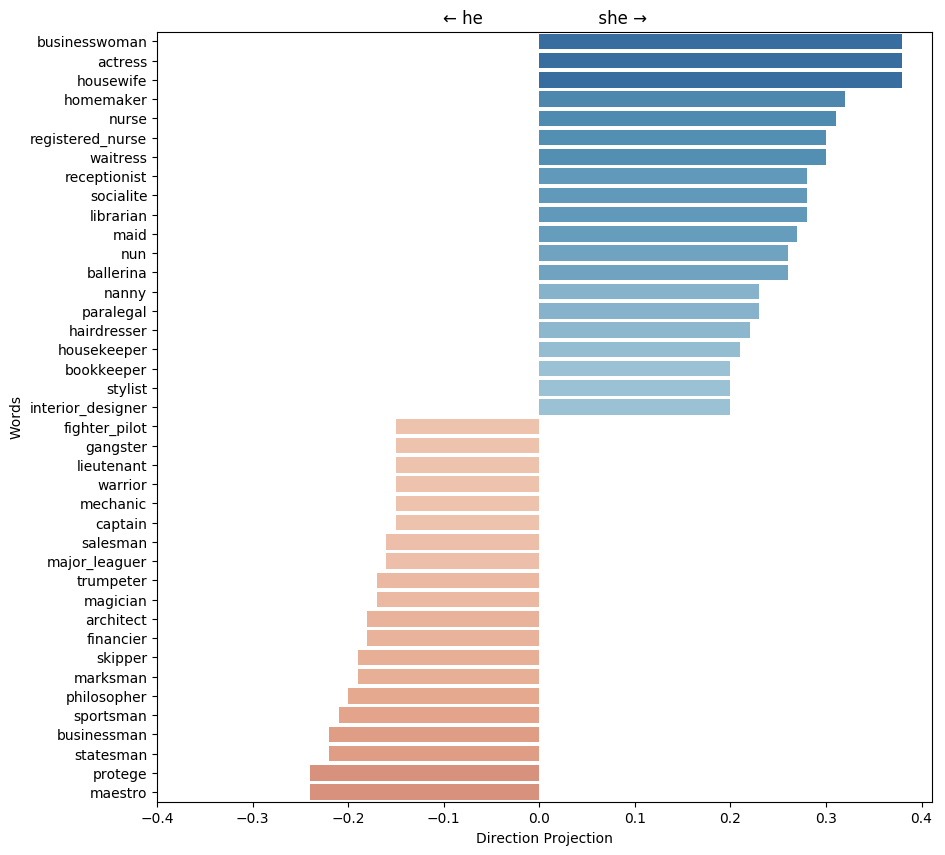

In [15]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_bias.plot_projection_scores(n_extreme=20, ax=ax);

**Extra** - Visualizing gender bias with [Word Clouds](http://wordbias.umiacs.umd.edu/)

This is an example of the type of work that you could do for a project

## 4.3 - Are the projections of occupation words on the gender direction related to the real world?

Let's take the percentage of female in various occupations from the Labor Force Statistics of 2017 Population Survey.

Taken from: [https://arxiv.org/abs/1804.06876](https://arxiv.org/abs/1804.06876)

In [16]:
from responsibly.we.data import OCCUPATION_FEMALE_PRECENTAGE

sorted(OCCUPATION_FEMALE_PRECENTAGE.items(), key=itemgetter(1))

[('carpenter', 2),
 ('mechanician', 4),
 ('construction_worker', 4),
 ('laborer', 4),
 ('driver', 6),
 ('sheriff', 14),
 ('mover', 18),
 ('developer', 20),
 ('farmer', 22),
 ('guard', 22),
 ('chief', 27),
 ('janitor', 34),
 ('lawyer', 35),
 ('cook', 38),
 ('physician', 38),
 ('ceo', 39),
 ('analyst', 41),
 ('manager', 43),
 ('supervisor', 44),
 ('salesperson', 48),
 ('editor', 52),
 ('designers', 54),
 ('accountant', 61),
 ('auditor', 61),
 ('writer', 63),
 ('baker', 65),
 ('clerk', 72),
 ('cashier', 73),
 ('counselors', 73),
 ('attendant', 76),
 ('teacher', 78),
 ('sewer', 80),
 ('librarian', 84),
 ('assistant', 85),
 ('cleaner', 89),
 ('housekeeper', 89),
 ('nurse', 90),
 ('receptionist', 90),
 ('hairdressers', 92),
 ('secretary', 95)]

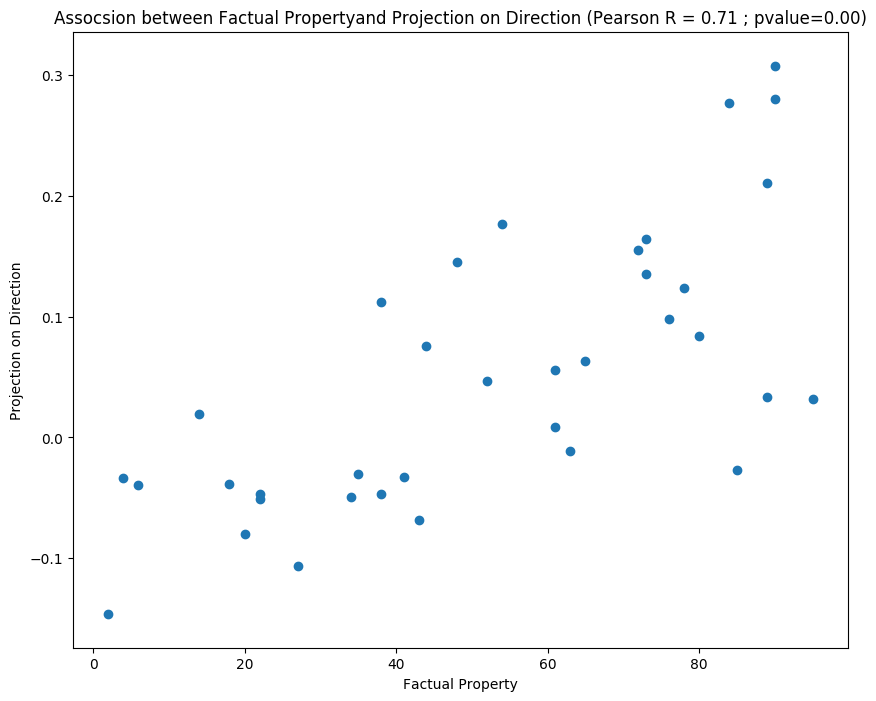

In [17]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_bias.plot_factual_association(ax=ax);

## 4.4 Word Embeddings Encoding Gender Stereotypes

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). [Word embeddings quantify 100 years of gender and ethnic stereotypes](https://www.pnas.org/content/pnas/115/16/E3635.full.pdf). Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.

In [ ]:
Image("./images/gender-bias-over-decades.png")

<small>Data: Google Books/Corpus of Historical American English (COHA)</small>

## 4.5 - Direct Bias Measure

1. Project each **neutral profession name** on the gender direction
2. Calculate the absolute value of each projection
3. Average it all

In [ ]:
# using responsibly
w2v_small_gender_bias.calc_direct_bias()

In [ ]:
# what responsibly does:
neutral_profession_projections = [w2v_small[word] @ w2v_small_gender_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_profession_projections = [abs(proj) for proj in neutral_profession_projections]

sum(abs_neutral_profession_projections) / len(abs_neutral_profession_projections)

## 4.6 - Indirect Bias Measure
Similarity due to shared "gender direction" projection

In [ ]:
w2v_small_gender_bias.generate_closest_words_indirect_bias('softball',
                                                           'football')

## 🐳 **Questions** 🐳

- Building off the example in section **4.2**, calculate three additional projects of the gender direction onto three words of your choice

In [21]:
# Calculate three additional gender projections here
gender_direction @ w2v_small['teacher']

0.13751496

In [24]:
gender_direction @ w2v_small['engineer']

-0.11862137

In [23]:
gender_direction @ w2v_small['nurse']

0.2808597


- What do you think of the idea of a gender direction as quantified in section **4.1** above?

    - What do you think the formula does right?
    The formula can calculate a word's level of association with 'she' or 'he' by calculating the difference between the he and she word vectors. If the word similarity is positive, that word is more associated with 'she.' If the word similarity is negative, the word is more associated with 'he.'

    - What do you think the formula does wrong?
    The formula assumes that the two terms are mutually exclusive. Either a word can be more associated with 'he' and 'she.' This formula is in danger of subscribing to the idea of the gender binary (man or woman), when we know that gender exists on the spectrum. As such, this may not be an accurate and inclusive formula to use.

- Using the methods shown in **4.1** and **4.2**, define a new direction for a concept of your choice besides gender

    - What is your concept?
    
    Colors.
    
    - What are your starting and ending words?
    
    Black and white.

- Calculate the new concept direction, and project it onto three words of your choice below

In [29]:
### Calculate the new direction
color_direction = w2v_small['white'] - w2v_small['black']

color_direction /= norm(color_direction)


### Project it onto three words of your choice
print(color_direction @ w2v_small['blue'])
print(color_direction @ w2v_small['darkness'])
print(color_direction @ w2v_small['clouds'])

0.18028574
-0.061909273
0.03219437


- What do your results tell you?

Blue is more associated with white than black. Darkness is more associated with black than white. Clouds is more associated with white than black. These results are expected. However, blue had the strongest association score and clouds had the weakest. This is somewhat unexpected, as darkness is black and clouds are white. But I can understand that blue is also a color and so perhaps being part of the same concept category as white and black has more weight in determining a word's association score.

# Part 5: Mitigating Bias

> We intentionally do not reference the resulting embeddings as "debiased" or free from all gender bias, and
prefer the term "mitigating bias" rather that "debiasing," to guard against the misconception that the resulting
embeddings are entirely "safe" and need not be critically evaluated for bias in downstream tasks. <small>James-Sorenson, H., & Alvarez-Melis, D. (2019). [Probabilistic Bias Mitigation in Word Embeddings](https://arxiv.org/pdf/1910.14497.pdf). arXiv preprint arXiv:1910.14497.</small>

## 5.1 - Neutralize

We will remove the gender projection from all the words, except the gender-specific ones, and then normalize.

We need to "learn" what are the gender-specific words in the vocabulary for a seed set of gender-specific words (we do this by semi-automatic use of [WordNet](https://en.wikipedia.org/wiki/WordNet))

In [30]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [31]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340498348297062 after =  -2.879667095057048e-10


In [32]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.2209519181777572 after =  -0.2209519181777572


In [33]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474834677359 after =  0.3403474834677359


In [34]:
w2v_small_gender_debias.calc_direct_bias()

1.1915945484669477e-09

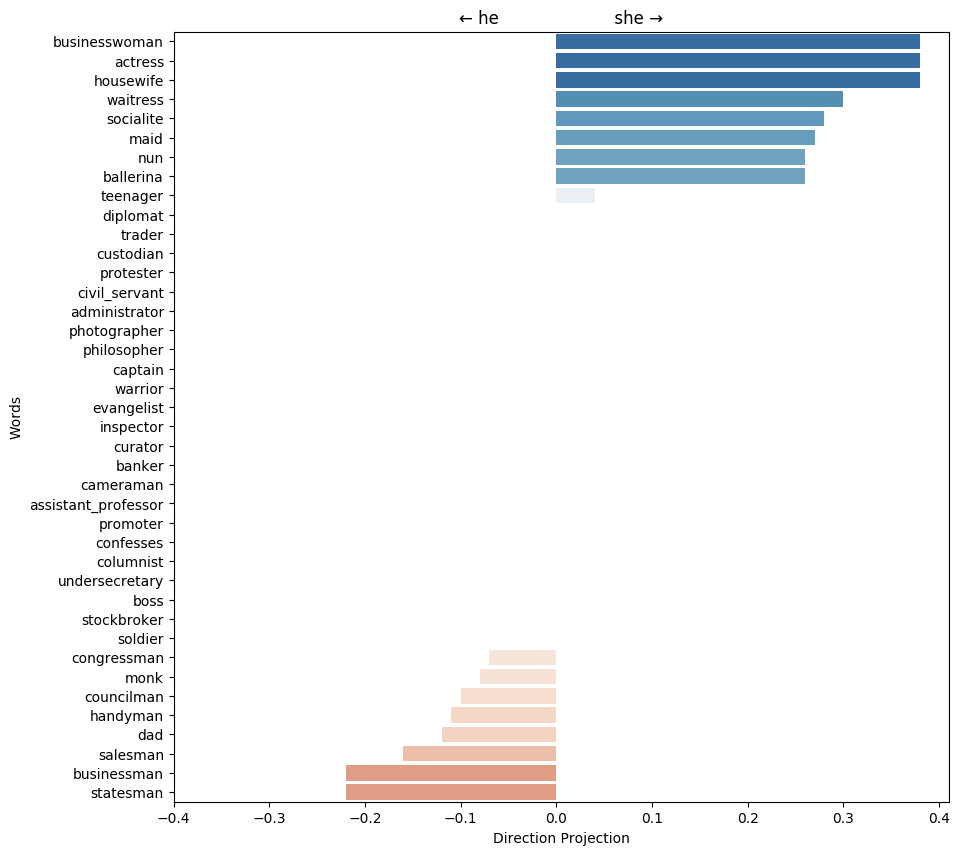

In [35]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

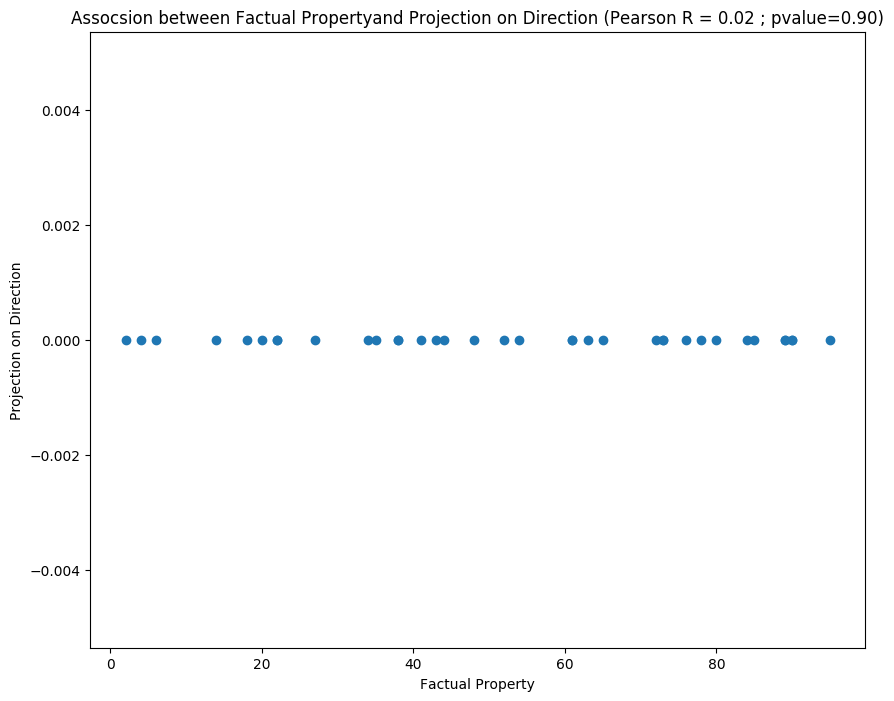

In [36]:
f, ax = plt.subplots(1, figsize=(10, 8))

w2v_small_gender_debias.plot_factual_association(ax=ax);

## 5.2 Equalize

In [37]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.30331385

In [38]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.44708428

Notice that the projection of "grandfather" and "grandmother" onto the now neutral word "babysitter" are not equal, even though we have "debiased" our embedding. We might prefer that in a "debiased" embedding, "grandfather" and "grandmother" have roughly the same projection onto neutral words. Below you can see an example of some of the pairs we are interested in equalizing.

In [39]:
BOLUKBASI_DATA['gender']['equalize_pairs'][:10]

[['monastery', 'convent'],
 ['spokesman', 'spokeswoman'],
 ['Catholic_priest', 'nun'],
 ['Dad', 'Mom'],
 ['Men', 'Women'],
 ['councilman', 'councilwoman'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['prostate_cancer', 'ovarian_cancer'],
 ['testosterone', 'estrogen']]

## 5.3 Hard Debias = Neutralize + Equalize

Now we debias by both neutralizing as we did before along with equalizing across the pairs we indentified above (note that the list that was printed out is not exhaustive).

In [40]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='hard', inplace=False)

In [41]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340498348297062 after =  -2.879667095057048e-10


In [42]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.2209519181777572 after =  -0.34693386205845267


In [43]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474834677359 after =  0.346933864992657


In [44]:
w2v_small_gender_debias.calc_direct_bias()

1.2080385124779453e-09

In [45]:
w2v_small_gender_debias.model['grandfather'] @ w2v_small_gender_debias.model['babysitter']

0.37519908

In [46]:
w2v_small_gender_debias.model['grandmother'] @ w2v_small_gender_debias.model['babysitter']

0.37519908

Notice that "grandfather" and "grandmother" now have (almost exactly) the same projection onto "babysitter".

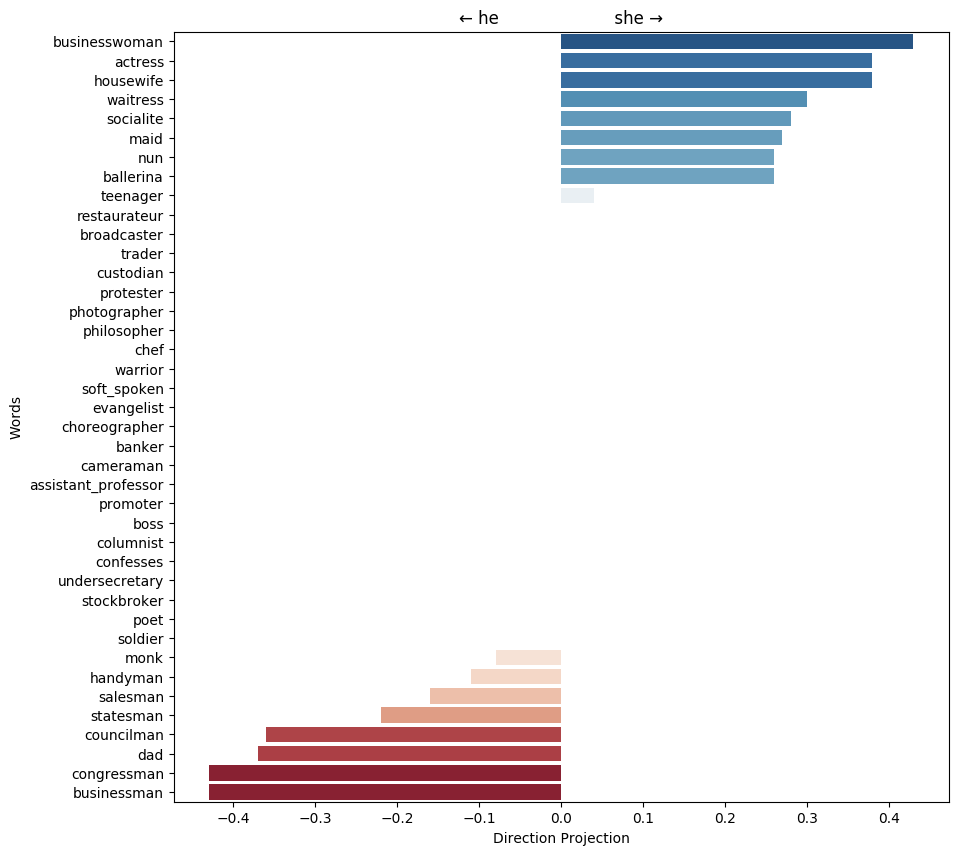

In [47]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

The disadvantage of equalization is that it might remove meaningful associations, such as the verb meaning of "grandfather", e.g. "to grandfather a regulation". Equalization removes this distinction.

## 5.4 - Compare Preformances

After debiasing, the performance of the word embedding (using standard benchmarks) only gets slightly worse!

In [48]:
w2v_small_gender_bias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.645           0.000       0.688            0.000   
 RG65           0.576           0.232       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.650           0.000       0.674            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.456           0.000       0.444            0.000   
 TR9856         0.666           0.000       0.676            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.750
 Google      0.729)

In [49]:
w2v_small_gender_debias.evaluate_word_embedding()

(           pearson_r  pearson_pvalue  spearman_r  spearman_pvalue  \
 WS353          0.643           0.000       0.685            0.000   
 RG65           0.574           0.234       0.493            0.321   
 RW             0.611           0.000       0.655            0.000   
 Mturk          0.651           0.000       0.675            0.000   
 MEN            0.766           0.000       0.782            0.000   
 SimLex999      0.459           0.000       0.447            0.000   
 TR9856         0.665           0.000       0.674            0.000   
 
            ratio_unkonwn_words  
 WS353                    9.915  
 RG65                    14.286  
 RW                      77.384  
 Mturk                    1.558  
 MEN                     15.148  
 SimLex999                1.702  
 TR9856                  89.722  ,
             score
 MSR-syntax  0.751
 Google      0.726)

## 🐳 **Questions** 🐳

- What is "neutralizing", and what is "equalizing" in the context of "hard debiasing", and how do they differ? 
    
    <small>You may find it helpful to look at the following paper from class (you may copy the definitions from the paper, but the explanation on how they differ should be your own):</small>
    <small>[Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://arxiv.org/pdf/1607.06520.pdf)</small>

    Neutralizing ensures that gender neutral words are zero in the gender subspace. Equalize ensures that any neutral word is equidistant to all words in each equaity set.